![](Rydiqule_Logo_Transparent_300.png)

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [4]:
import rydiqule as rq
from rydiqule.sensor_utils import get_rho_ij

# 3-photon Rydberg EIT #

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/3-photon_example.ipynb).

We demonstrate three photon coherent excitations using the system studied in Taicharoen et. al. PRA 063427 (2019). This is a rubidium vapor with a $5S_{1/2}\rightarrow5P_{3/2}\rightarrow5D_{5/2}\rightarrow28F_{7/2}$ excitation pathway, with corresponding optical fields of 780 nm, 776 nm, and 1260 nm. These fields are labelled probe, dressing, and coupling, respectively.

Here we demonstrate using rydiqule to solve this system under three conditions: 

1) Cold atoms
2) Warm atoms, colinear optical beams
3) Warm atoms, doppler-free angles

Because there are three optical fields, the basic coherent feature observed, on resonance, is expected to the absorptive (rather than transmissive like EIT). Going to warm atoms, this feature broadens signficantly, and other coherent features can arise at non-zero detunings of the fields. Going to a Doppler-free excitation in warm atoms, we find that a transmissive feature is observed on resonance. This feature is significantly narrower than those observed in the colinear case.

## Doppler-free, 3 photon excitation ##

With all three fields resonant, we expect to see Electromagnetically-Induced-Absorption (EIA) instead of EIT.

In [5]:
detunings = np.linspace(-20,20,41)

probe = {'states':(0,1), 'rabi_frequency':2*np.pi*0.1,'detuning':2*np.pi*0}
dress = {'states':(1,2), 'rabi_frequency':2*np.pi*2}
couple = {'states':(2,3), 'rabi_frequency':2*np.pi*2, 'detuning':2*np.pi*detunings}

basis_size = 4
gam = np.zeros((basis_size,basis_size),dtype=np.float64)
gam[1,0] = 6
gam[2,1] = 0.66
gam[3,2] = 10e-3
gamma_matrix = 2*np.pi*gam

sensor = rq.Sensor(basis_size)
sensor.add_couplings(probe,couple)
sensor.set_gamma_matrix(gamma_matrix)

In [6]:
dress['detuning'] = 2*np.pi*0
sensor.add_couplings(dress)
sols = rq.solve_steady_state(sensor)

Text(0, 0.5, 'Im($\\rho_{10}$)')

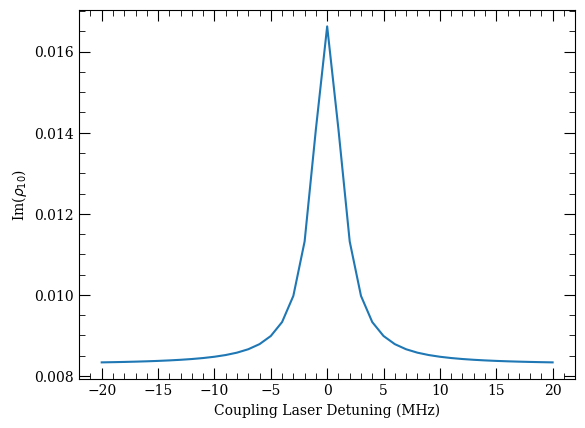

In [7]:
fig, ax = plt.subplots()
ax.plot(detunings, get_rho_ij(sols.rho,1,0).imag)
ax.set_xlabel("Coupling Laser Detuning (MHz)")
ax.set_ylabel(r"Im($\rho_{10}$)")

## Colinear 3-photon Excitation with Doppler Averaging ##

We can take our three fields and configure them in the (+,-,-) configuration of Taicharoen (2019). We will need to do Doppler averaging along the colinear axis to get the result. The magnitude of a field's kvector is defined such that it is the magnitude of the Doppler shift associated with the most probable speed of the Maxwell-Boltzmann distribution ($v_P\equiv\sqrt{2k_B T/m}$, where $k_B$ is Boltzmann's constant, $T$ is the gas temperature, and $m$ is the atomic mass). It should have units of Mrad/s like all other specifies quantities.

The following reproduces Figure 2b from Taicharoen et. al. PRA 063427 (2019). Note that having all fields resonant results in an EIA feature, but it now much broader than the Doppler-free case above. If the dressing field is detuning, EIT features are observed.

In [8]:
detunings = np.linspace(-200,200,201)

kp = 2*np.pi/780e-3*np.array([1,0,0])
kd = 2*np.pi/776e-3*np.array([-1,0,0])
kc = 2*np.pi/1260e-3*np.array([-1,0,0])
vP = 242.387 # m/s

###
probe = {'states':(0,1), 'rabi_frequency':2*np.pi*10, 'kvec':kp, 'detuning': 0}
dress = {'states':(1,2), 'rabi_frequency':2*np.pi*25, 'kvec':kd}
couple = {'states':(2,3), 'rabi_frequency':2*np.pi*18, 'detuning':2*np.pi*detunings, 'kvec':kc}
###

n = 4
sensor = rq.Sensor(n, vP=vP)
sensor.add_decoherence((1,0), 2*np.pi*6)
sensor.add_decoherence((2,1), 2*np.pi*0.66)
sensor.add_decoherence((3,2), 2*np.pi*10e-3)

sensor.add_couplings(probe,couple)

In [9]:
dress['detuning'] = 2*np.pi*0
sensor.add_couplings(dress)
sols0 = rq.solve_steady_state(sensor,doppler=True)

In [10]:
dress['detuning'] = 2*np.pi*20
sensor.add_couplings(dress)
solsp20 = rq.solve_steady_state(sensor,doppler=True)

In [11]:
dress['detuning'] = -2*np.pi*20
sensor.add_couplings(dress)
solsm20 = rq.solve_steady_state(sensor,doppler=True)

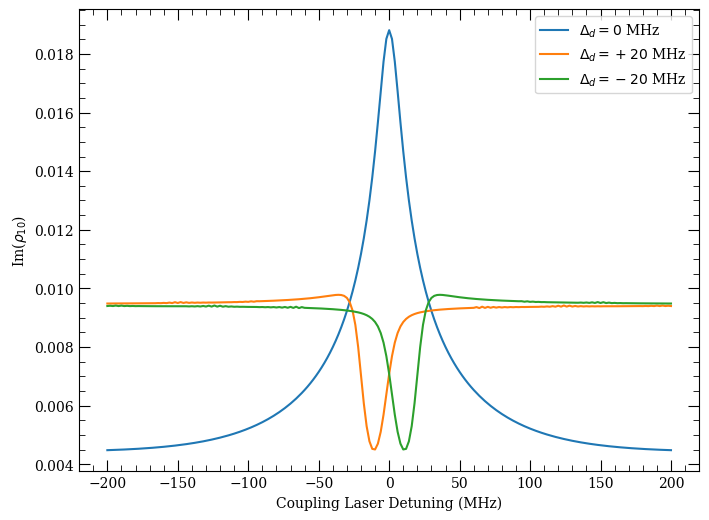

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(detunings, get_rho_ij(sols0.rho,1,0).imag, label="$\\Delta_d= 0$ MHz")
ax.plot(detunings, get_rho_ij(solsp20.rho,1,0).imag, label="$\\Delta_d= +20$ MHz")
ax.plot(detunings, get_rho_ij(solsm20.rho,1,0).imag, label="$\\Delta_d= -20$ MHz")
ax.set_xlabel("Coupling Laser Detuning (MHz)")
ax.set_ylabel(r"Im($\rho_{10}$)")
ax.legend()

## Doppler-Free Angles ##

We can take the same co-propagating system, and instead change the angles of the three beams such that $k_p+k_d+k_c\approx0$. 

We now need to do Doppler averaging in two orthogonal dimensions. Rydiqule automatically detects how many non-zero dimensions are present in the field kvectors and averages over the appropriate number of spatial dimensions.

In [13]:
detunings = np.linspace(-20,20,21)

kp = 2*np.pi/780e-3*np.array([1,0,0])
kd = 2*np.pi/776e-3*np.array([-1,0,0])
kc = 2*np.pi/1260e-3*np.array([-1,0,0])
vP = 242.387 # m/s

# rotate to doppler free angles
rd = R.from_euler('z',-35.964,degrees=True)
rc = R.from_euler('z',72.4718,degrees=True)
kdDF = rd.apply(kd)
kcDF = rc.apply(kc)

probe = {'states':(0,1), 'rabi_frequency':2*np.pi*10, 'kvec':kp, 'detuning':0}
dress = {'states':(1,2), 'rabi_frequency':2*np.pi*25, 'kvec':kdDF}
couple = {'states':(2,3), 'rabi_frequency':2*np.pi*18, 'detuning':2*np.pi*detunings, 'kvec':kcDF}

n = 4
sensor = rq.Sensor(n, vP=vP)
sensor.add_decoherence((1,0), 2*np.pi*6)
sensor.add_decoherence((2,1), 2*np.pi*0.66)
sensor.add_decoherence((3,2), 2*np.pi*10e-3)

sensor.add_couplings(probe,couple)

In [14]:
print('Residual fractional kvector sum due to round-off errors')
print((kp+kdDF+kcDF)/np.sqrt(kp.dot(kp)))

Residual fractional kvector sum due to round-off errors
[-1.41309045e-08 -4.99652620e-07  0.00000000e+00]


In [15]:
dress['detuning'] = 2*np.pi*0
sensor.add_couplings(dress)
sols0DF = rq.solve_steady_state(sensor,doppler=True)

Text(0, 0.5, 'Im($\\rho_{10}$)')

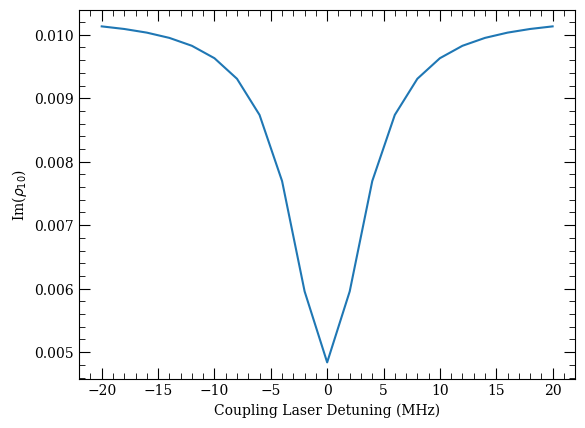

In [16]:
fig, ax = plt.subplots()
ax.plot(detunings, get_rho_ij(sols0DF.rho,1,0).imag)
ax.set_xlabel("Coupling Laser Detuning (MHz)")
ax.set_ylabel(r"Im($\rho_{10}$)")

We observe a significantly narrower feature than in the collinear case, and it is now EIT instead of EIA.

The authors recognize financial support from the Defense Advanced Research Projects Agency (DARPA).  Rydiqule has been approved for unlimited public release by DEVCOM Army Research Laboratory and DARPA.  This software is released under the xx licence through the University of Maryland Quantum Technology Center.  The views, opinions and/or findings expressed here are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.